In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

import sys
sys.path.append('/content/gdrive/My Drive/Food_VR')

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time 
import seaborn as sns
import csv

In [ ]:
class DataPlotterService():
    def __init__(self, participantID, eventDataInputCSV, annotationDataInputCSV, eventTimeStampColumn, selectedColumns, compare = False):
        self.selectedColumns = selectedColumns
        self.eventDataInputCSV = eventDataInputCSV
        self.annotationDataInputCSV = annotationDataInputCSV
        self.paricipantID = participantID
        self.selectedColumns = selectedColumns        
        self.compareAttributes = compare
    
    def PlotTimeSeriesData(self):   
        wq
        event_df = pd.read_csv(self.eventDataInputCSV,encoding='latin1')
        eventStartTime = event_df[eventTimeStampColumn].iat[0]
        eventEndTime = event_df[eventTimeStampColumn].iat[-1]            
        
        #Converting the timestamps to relative timestamp and setting the relative timestamp of the event as the index of the dataframe
        event_df.index = ((event_df[eventTimeStampColumn] - eventStartTime)/1000/60)     
        annotation_df = pd.read_csv(annotationDataInputCSV,encoding='latin1')
        annotation_df.set_index("ID", inplace=True)
        annotationTimeStamps = annotation_df.loc[participantID].to_dict()
                      
        #Converting annotation timestamps to relative timestamp
        annotationsList = []
        annotationPairs = []
        annotationTimeStamp = 0
        annotationEdgeCounter = 0        
        for key, value in annotationTimeStamps.items():
            
            # Assuming the timestamp is recorded at GMT not local time.            
            if time.localtime((value/1000)).tm_isdst == 0:                
                annotationTimeStamp = (value) - 18000                
            else: 
                annotationTimeStamp = (value) - 14400
                
            relativeTimeStamp = (annotationTimeStamp - eventStartTime)/1000/60              
            
            if relativeTimeStamp >= event_df.index[0] and relativeTimeStamp <= event_df.index[-1]:                               
                annotationPairs.append((relativeTimeStamp, key, 'r'))
                annotationEdgeCounter += 1
                if annotationEdgeCounter == 2:
                    annotationsList.append(annotationPairs)
                    annotationPairs = []
                    annotationEdgeCounter = 0   
                    
        #Plotting starts here.      
        # Depeniding on the inputs to the class instantiation, one of the following plotting options execute. 
        if compare == True and not self.selectedColumns:
            event_df.plot(figsize=(15,4))
        elif not self.selectedColumns:
            event_df.plot(subplots=True, figsize=(15,25))
        elif compare == True:
            event_df.plot(x=self.selectedColumns[0], y=self.selectedColumns[1:], style='.')
        else:
            fig, axes = plt.subplots(len(self.selectedColumns),1, figsize=(14,8), sharex=True)        
            event_df.plot(y=self.selectedColumns, subplots=True, figsize=(40, 8), ax=axes)  
        
        print('Ovralpping annotations during the event\n',annotationsList)
        for annotations in annotationsList:
            for timeStamp, eventName, clr in annotations:
                for ax in axes:
                    ax.legend(loc='center right', bbox_to_anchor=(-0.05, 0.5))
                    ax.axvspan(annotations[0][0], annotations[1][0], color=sns.xkcd_rgb['yellow'], alpha=0.5)
                    ax.axvline(x=timeStamp, color=clr)
                    ax.text(timeStamp, ax.get_ylim()[1]-4, eventName,
                              horizontalalignment='center',
                              verticalalignment='center',
                              color="black",
                              bbox=dict(facecolor='white', alpha=0.55))

Ovralpping annotations during the event
 [[(6.511328165690104, 'E1-\xa0 VR baseline start', 'r'), (14.663802164713541, 'F1- VR baseline end', 'r')]]


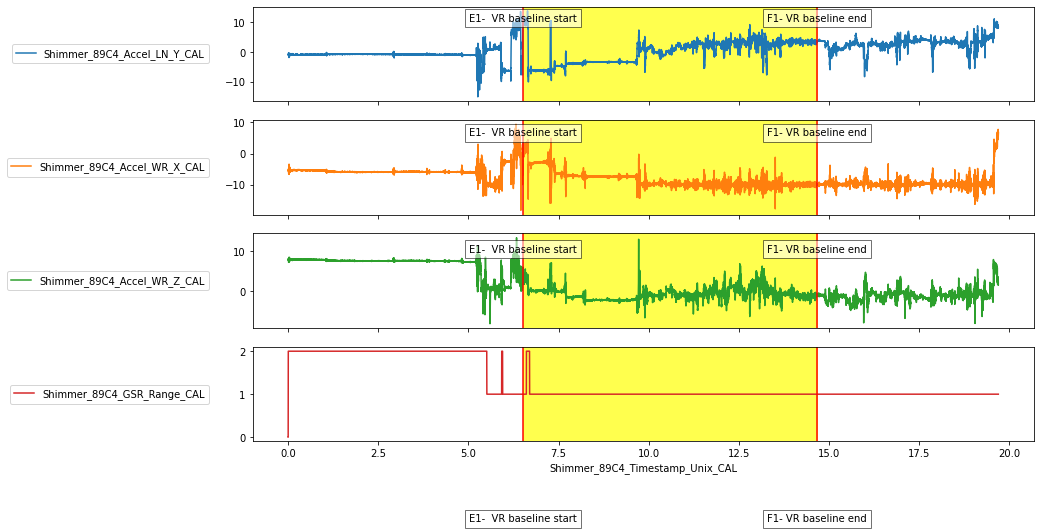

In [ ]:
participantID = 4 
eventDataInputCSV = '/content/drive/My Drive/ColabNotebooks/IndependentStudy_HDinYA_Kirubel/Subj_VR_1058_Session1_Shimmer_89C4_Calibrated_SD.csv'
annotationDataInputCSV = '/content/drive/My Drive/ColabNotebooks/IndependentStudy_HDinYA_Kirubel/VR Timestamps for Phase B & D_W&SP20_mock.csv'
eventTimeStampColumn = 'Shimmer_89C4_Timestamp_Unix_CAL'
SelectedColumns = ["Shimmer_89C4_Accel_LN_Y_CAL", "Shimmer_89C4_Accel_WR_X_CAL", "Shimmer_89C4_Accel_WR_Z_CAL", "Shimmer_89C4_GSR_Range_CAL"]
compare = False
myPlotterService = DataPlotterService(participantID, eventDataInputCSV, annotationDataInputCSV, eventTimeStampColumn, SelectedColumns, compare)
myPlotterService.PlotTimeSeriesData()

# **Epochs to DateTime Converter Service:** Notes and Assumptions
*   The input file should be preprocessed to remove the forward-slash, "/", character and any trailing blank spaces.
*   The implementation assumes that your first column contains the ID values which will be used as key identifiers and expects you to specify if your file contains a header row. 
*   Instantiating the TimeConverterService class requires you to specify the path to the input file, 
the path of the outputfile, and a boolean value indicating if a header row exists.

In [4]:
class TimeConverterService():    
    def __init__(self, originalFile, convertedFile, headerExists):
        self.originalFile = originalFile
        self.convertedFile = convertedFile
        self.headerExists = headerExists
        self.headerColumns = []
        self.timeStamps = {}
        self.fileContent = [self.headerColumns, self.timeStamps]
        
    
    # This method picks CSV file from the specified path, converts it's epoch values to localTime-dateTime strings and returns an equivalent of the input data in a form of the specified data structure. 
    def ConvertCsvEpochsToDateTime (self):
        with open(self.originalFile) as csvfile:
            
            #Specify the delimiter used for your CSV file for reader to capture your cells.             
            readCSV = csv.reader(csvfile, delimiter=',')  
            
            currentRow = 0
            try:
                for row in readCSV:
                    
                    # After validating if a header-row exists, we build an array of header row cell values.                    
                    if self.headerExists == True and currentRow == 0:        
                        for i in range(len(row)):
                            self.headerColumns.append(row[i]) 
                    else:            
                        self.timeStamps.setdefault(row[0], []) 
                        i = 1
                        while i < len(row):  
                            epoch = float(row[i])
                            localTime = 0
                            
                            # Here, we use the "time isdst" method to check if the given epoch seconds are in DST in the local time zone. 
                            # if the epoch is DST, we subtract 5 hours, otherwise, 4 hours for when epoch is in eastern standard time, EST.
                            
                            if time.localtime((epoch/1000)).tm_isdst == 0:
                                localTime = (epoch/1000) - 18000
                            else: 
                                localTime = (epoch/1000) - 14400
                                
                            # Here, we convert the localTime value to its string representation and keep record of it in its row.                            
                            time_stamp = time.strftime('%m/%d/%Y %H:%M:%S',  time.gmtime(localTime))
                            self.timeStamps[row[0]].append(time_stamp) 
                            
                            i += 1                    
                    currentRow = 1  
            except ValueError:
                print("Invalid time description. Please clean your input data!")
                raise
        return self.timeStamps
    
    
    # The following method writes the converted epochs to datetime string data to a CSV file.     
    def WriteConvertedDateTimesToCSV (self):
        try:
            with open(self.convertedFile, 'w') as csvfile:  
                csvwriter = csv.writer(csvfile)
                
                # Here, we stream to the header column  and write it as a row at once after validating that a header-row exists.
                if self.headerExists == True:
                    csvwriter.writerow(self.headerColumns) 
                
                # Iterating over the dictionary with participant Id key, we itterate over the array to write the column values.
                for key, value in self.timeStamps.items():
                    row = []
                    row.append(key)
                    for cell in value:
                        row.append(cell)
                    csvwriter.writerow(row)
            print('Your file is created!')
        except:
            print("Error occured when writing to file.")
            raise

# **Test Run**: Use the TimeConverterService class to convert epochs to date-time values. 
(The paths to the input and output file will be the same directory path this notebook is found in)

Follow the steps bellow to convert your file. 

1.   Specify the paths and if your input data has a header row. The specified paths/names are only placeholders.
2.   Pass the variables you created and instantiate a the TimeConverterService. 
3.   Access the "EpochsToDateTime" method of the service to do the converstion and set the class attribute which will capture your data.
4.   Make a call to the "WriteConvertedDateTimesToCSV" method to write your converted data to disc. 

In [ ]:
originalFile = '/content/drive/My Drive/ColabNotebooks/IndependentStudy_HDinYA_Kirubel/VR Timestamps for Phase B & D_W&SP20.csv'
convertedFile = '/content/drive/My Drive/ColabNotebooks/IndependentStudy_HDinYA_Kirubel/convertedTimeStamps.csv'
headerExists = True 
csvService = TimeConverterService(originalFile, convertedFile, headerExists)
csvService.ConvertCsvEpochsToDateTime()
csvService.WriteConvertedDateTimesToCSV()